In [11]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge, LassoCV,LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 30)

#sns.set_style("whitegrid")
#plt.style.use('bmh')
plt.style.use('seaborn-whitegrid')

# this allows plots to appear directly in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
train_df = pd.read_csv('data/train.csv')
train_df['data_set'] = 'train'
test_df = pd.read_csv('data/test.csv')
test_df['data_set'] = 'test'
# combine train and test data into one df
test_df['registered'] = 0
test_df['casual'] = 0
test_df['count'] = 0

all_df = pd.concat([train_df, test_df])
# parse datetime colum & add new time related columns
dt = pd.DatetimeIndex(all_df['datetime'])
all_df.set_index(dt, inplace=True)

# logarithmic transformation of dependent cols
# (adding 1 first so that 0 values don't become -inf)
for col in ['casual', 'registered', 'count']:
    all_df[f'{col}_log'] = np.log(all_df[col] + 1)

all_df['date'] = dt.date # yyyymmdd
all_df['day'] = dt.day # dd
all_df['month'] = dt.month # mm
all_df['year'] = dt.year # yyyy
all_df['hour'] = dt.hour # hh
all_df['dow'] = dt.dayofweek #曜日 Mon:0 Tue:1 Wed:2 Thu:3 Fri:4 Sat:5 Sun:6
all_df['woy'] = dt.isocalendar().week #その日の週が年間で見ると何番目の週かを表す数字 [dt.weekofyear]は deprecated

# add a count_season column using join
by_season = all_df[all_df['data_set'] == 'train'].copy().groupby(['season'])[['count']].agg(sum)
by_season.columns = ['count_season']
all_df = all_df.join(by_season, on='season')


# feature engineer a new column whether its a peak hour or not
all_df['peak'] = all_df[['hour', 'workingday']]\
    .apply(lambda df: 3 if ((df['workingday'] == 1 and (df['hour'] == 8 or 17 <= df['hour'] <= 18)) \
                            or (df['workingday'] == 0 and 11 <= df['hour'] <= 17)) else \
                            ( 2 if ((df['workingday'] == 1 and (df['hour'] == 7 or df['hour'] == 9 or df['hour'] == 16 or 19 <= df['hour'] <= 20)) \
                            or (df['workingday'] == 0 and (df['hour'] == 10 or 18 <= df['hour'] <= 19))) else \
                            ( 1 if ((df['workingday'] == 1 and (10 <= df['hour'] <= 15 or 21 <= df['hour'] <= 22)) \
                            or (df['workingday'] == 0 and (8 <= df['hour'] <= 9 or 20 <= df['hour'] <= 23))) else 0)), axis = 1)

#ここの修正の仕方は、間違っているので要修正！
# sandy
#all_df['holiday'] = all_df[['month', 'day', 'holiday', 'year']]\
#    .apply(lambda df: 1 if (df['year'] == 2012 and df['month'] == 10 and df['day'] == 30) else 0, axis = 1)
# 修正後↓
all_df['holiday'] = all_df[['month', 'day', 'holiday', 'year']]\
    .apply(lambda df: 1 if (df['year'] == 2012 and df['month'] == 10 and df['day'] == 30) else df['holiday'], axis = 1)


# christmas and others
all_df['holiday'] = all_df[['month', 'day', 'holiday']]\
    .apply(lambda df: 1 if (df['month'] == 12 and df['day'] in [24, 26, 31]) else df['holiday'], axis = 1)
all_df['workingday'] = all_df[['month', 'day', 'workingday']]\
    .apply(lambda df: 0 if df['month'] == 12 and df['day'] in [24, 31] else df['workingday'], axis = 1)
# これは流石に気づかない気がする。。。気づけない気がする。。。
def get_day(day_start):
    day_end = day_start + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day_start, day_end, freq="H")

# tax day
all_df.loc[get_day(datetime(2011, 4, 15)), "workingday"] = 1
all_df.loc[get_day(datetime(2012, 4, 16)), "workingday"] = 1

# thanksgiving friday
all_df.loc[get_day(datetime(2011, 11, 25)), "workingday"] = 0
all_df.loc[get_day(datetime(2012, 11, 23)), "workingday"] = 0

# tax day
all_df.loc[get_day(datetime(2011, 4, 15)), "holiday"] = 0
all_df.loc[get_day(datetime(2012, 4, 16)), "holiday"] = 0

# thanksgiving friday
all_df.loc[get_day(datetime(2011, 11, 25)), "holiday"] = 1
all_df.loc[get_day(datetime(2012, 11, 23)), "holiday"] = 1

#storms
all_df.loc[get_day(datetime(2012, 5, 21)), "holiday"] = 1

#tornado
all_df.loc[get_day(datetime(2012, 6, 1)), "holiday"] = 1
# from histogram
all_df['ideal'] = all_df[['temp', 'windspeed']]\
    .apply(lambda df: 1 if (df['temp'] > 27 and df['windspeed'] < 30) else 0, axis = 1)
    
all_df['sticky'] = all_df[['humidity', 'workingday']]\
    .apply(lambda df: 1 if (df['workingday'] == 1 and df['humidity'] >= 60) else 0, axis = 1)

# temperature
all_df.loc[all_df['temp'] < 10,'temp_cat'] = 1
all_df.loc[(all_df['temp'] >= 10) & (all_df['temp'] < 15),'temp_cat'] = 2
all_df.loc[(all_df['temp'] >= 15) & (all_df['temp'] < 20),'temp_cat'] = 3
all_df.loc[(all_df['temp'] >= 20) & (all_df['temp'] < 25),'temp_cat'] = 4
all_df.loc[(all_df['temp'] >= 25) & (all_df['temp'] < 30),'temp_cat'] = 5
all_df.loc[(all_df['temp'] >= 30) & (all_df['temp'] < 35),'temp_cat'] = 6
all_df.loc[(all_df['temp'] >= 35),'temp_cat'] = 7

# humidity many category
all_df.loc[all_df['humidity'] < 10,'humidity_cat_many'] = 0
all_df.loc[(all_df['humidity'] >= 10) & (all_df['humidity'] < 20),'humidity_cat_many'] = 1
all_df.loc[(all_df['humidity'] >= 20) & (all_df['humidity'] < 30),'humidity_cat_many'] = 2
all_df.loc[(all_df['humidity'] >= 30) & (all_df['humidity'] < 40),'humidity_cat_many'] = 3
all_df.loc[(all_df['humidity'] >= 40) & (all_df['humidity'] < 50),'humidity_cat_many'] = 4
all_df.loc[(all_df['humidity'] >= 50) & (all_df['humidity'] < 60),'humidity_cat_many'] = 5
all_df.loc[(all_df['humidity'] >= 60) & (all_df['humidity'] < 70),'humidity_cat_many'] = 6
all_df.loc[(all_df['humidity'] >= 70) & (all_df['humidity'] < 80),'humidity_cat_many'] = 7
all_df.loc[(all_df['humidity'] >= 80) & (all_df['humidity'] < 90),'humidity_cat_many'] = 8
all_df.loc[(all_df['humidity'] >= 90),'humidity_cat_many'] = 9

# humidity not many category
all_df.loc[all_df['humidity'] < 20,'humidity_cat_less'] = 0
all_df.loc[(all_df['humidity'] >= 20) & (all_df['humidity'] < 40),'humidity_cat_less'] = 1
all_df.loc[(all_df['humidity'] >= 40) & (all_df['humidity'] < 60),'humidity_cat_less'] = 2
all_df.loc[(all_df['humidity'] >= 60) & (all_df['humidity'] < 80),'humidity_cat_less'] = 3
all_df.loc[(all_df['humidity'] >= 80),'humidity_cat_less'] = 4

# windspeed
all_df.loc[all_df['windspeed'] < 5,'wind_cat'] = 0
all_df.loc[(all_df['windspeed'] >= 5) & (all_df['windspeed'] < 10),'wind_cat'] = 1
all_df.loc[(all_df['windspeed'] >= 10) & (all_df['windspeed'] < 15),'wind_cat'] = 2
all_df.loc[(all_df['windspeed'] >= 15) & (all_df['windspeed'] < 20),'wind_cat'] = 3
all_df.loc[(all_df['windspeed'] >= 20) & (all_df['windspeed'] < 25),'wind_cat'] = 4
all_df.loc[(all_df['windspeed'] >= 25) & (all_df['windspeed'] < 30),'wind_cat'] = 5
all_df.loc[(all_df['windspeed'] >= 30) & (all_df['windspeed'] < 35),'wind_cat'] = 6
all_df.loc[(all_df['windspeed'] >= 35) & (all_df['windspeed'] < 40),'wind_cat'] = 7
all_df.loc[(all_df['windspeed'] >= 40) & (all_df['windspeed'] < 45),'wind_cat'] = 8
all_df.loc[(all_df['windspeed'] >= 45),'wind_cat'] = 9


In [13]:
# One-hot-Encoding for season
season_map = {1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'}
all_df['season_name'] = all_df['season'].map(lambda d : season_map[d])
temporary = pd.get_dummies(all_df['season_name'])
all_df['season_Fall'] = temporary['Fall']
all_df['season_Spring'] = temporary['Spring']
all_df['season_Summer'] = temporary['Summer']
all_df['season_Winter'] = temporary['Winter']

# One-hot-Encoding for weather
weather_map = {1:'Good', 2:'Normal', 3:'Bad', 4:'Worse'}
all_df['weather_name'] = all_df['weather'].map(lambda d : weather_map[d])
temporary = pd.get_dummies(all_df['weather_name'])
all_df['weather_Good'] = temporary['Good']
all_df['weather_Normal'] = temporary['Normal']
all_df['weather_Bad'] = temporary['Bad']
all_df['weather_Worse'] = temporary['Worse']

# One-hot-Encoding for other columns
all_df['day_copy'] = all_df['day']
all_df['month_copy'] = all_df['month']
all_df['year_copy'] = all_df['year']

In [14]:
all_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,data_set,casual_log,registered_log,count_log,date,day,month,year,hour,dow,woy,peak,ideal,wet,temp_cat,humidity_cat,wind_cat,season_name,season_Fall,season_Spring,season_Summer,season_Winter,weather_name,weather_Good,weather_Normal,weather_Bad,weather_Worse,day_copy,month_copy,year_copy
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,train,1.386294,2.639057,2.833213,2011-01-01,1,1,2011,0,5,52,0,0,0,1.0,8.0,0.0,Spring,0,1,0,0,Good,1,0,0,0,1,1,2011
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train,2.197225,3.496508,3.713572,2011-01-01,1,1,2011,1,5,52,0,0,0,1.0,8.0,0.0,Spring,0,1,0,0,Good,1,0,0,0,1,1,2011
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train,1.791759,3.332205,3.496508,2011-01-01,1,1,2011,2,5,52,0,0,0,1.0,8.0,0.0,Spring,0,1,0,0,Good,1,0,0,0,1,1,2011


In [15]:
all_df = pd.get_dummies(all_df,columns=['day_copy','month_copy','year_copy','hour','dow','woy','peak','temp_cat','humidity_cat_many','wind_cat'])

In [16]:
print(all_df.columns.tolist())

['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'data_set', 'casual_log', 'registered_log', 'count_log', 'date', 'day', 'month', 'year', 'ideal', 'wet', 'season_name', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 'weather_name', 'weather_Good', 'weather_Normal', 'weather_Bad', 'weather_Worse', 'day_copy_1', 'day_copy_2', 'day_copy_3', 'day_copy_4', 'day_copy_5', 'day_copy_6', 'day_copy_7', 'day_copy_8', 'day_copy_9', 'day_copy_10', 'day_copy_11', 'day_copy_12', 'day_copy_13', 'day_copy_14', 'day_copy_15', 'day_copy_16', 'day_copy_17', 'day_copy_18', 'day_copy_19', 'day_copy_20', 'day_copy_21', 'day_copy_22', 'day_copy_23', 'day_copy_24', 'day_copy_25', 'day_copy_26', 'day_copy_27', 'day_copy_28', 'day_copy_29', 'day_copy_30', 'day_copy_31', 'month_copy_1', 'month_copy_2', 'month_copy_3', 'month_copy_4', 'month_copy_5', 'month_copy_6', 'month_copy_7', 'month_copy_8', 'month_copy_9'

In [17]:
# instead of randomly splitting our training data 
# for cross validation, let's construct a framework that's more
# in line with how the data is divvied up for this competition
# (given first 19 days of each month, what is demand for remaining days)
# so, let's split our training data into 2 time contiguous datasets
# for fitting and validating our model (days 1-14 vs. days 15-19).

# also, since submissions are evaluated based on the
# root mean squared logarithmic error (RMSLE), let's replicate
# that computation as we test and tune our model.

train_df = all_df[all_df['data_set'] == 'train']
test_df = all_df[all_df['data_set'] == 'test']

def get_rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

def custom_train_valid_split(data, cutoff_day=15):
    train = data[data['day'] <= cutoff_day]
    valid = data[data['day'] > cutoff_day]

    return train, valid

def prep_train_data(data, input_cols):
    X = data[input_cols].values
    y_r = data['registered_log'].values
    y_c = data['casual_log'].values

    return X, y_r, y_c

# predict on validation set & transform output back from log scale
def predict_on_validation_set(model, input_cols):
    
    train, valid = custom_train_valid_split(train_df)
    y_pred_comb_l = []
    y_actual_comb_l = []

    for year_val in [2011,2012]:
        for month_val in range(1,13):

            #########print(f'Now,{year_val} {month_val} training and validating...')
            # prepare training & validation set
            train_tmp = train.query('year <= @year_val and month <= @month_val')
            valid_tmp = valid.query('year == @year_val and month == @month_val')

            X_train, y_train_r, y_train_c = prep_train_data(train_tmp, input_cols)
            X_valid, y_valid_r, y_valid_c = prep_train_data(valid_tmp, input_cols)

            # training and validating
            model_r = model.fit(X_train, y_train_r)
            y_pred_r = np.exp(model_r.predict(X_valid)) - 1

            model_c = model.fit(X_train, y_train_c)
            y_pred_c = np.exp(model_c.predict(X_valid)) - 1

            y_pred_comb = np.round(y_pred_r + y_pred_c)
            y_pred_comb[y_pred_comb < 0] = 0
            y_pred_comb_l.extend(y_pred_comb)

            y_actual_comb = np.exp(y_valid_r) + np.exp(y_valid_c) - 2
            y_actual_comb_l.extend(y_actual_comb)

            #rmsle = get_rmsle(y_pred_comb, y_actual_comb)
            #rmsle_l.append(rmsle)
    
    rmsle = get_rmsle(np.array(y_pred_comb_l),np.array(y_actual_comb_l))
    
    return (np.array(y_pred_comb_l), np.array(y_actual_comb_l), rmsle)


# predict on test set & transform output back from log scale
def predict_on_test_set(model, input_cols):
    
    y_pred_comb_l = []
    for year_val in [2011,2012]:
        for month_val in range(1,13):
            
            # prepare training set
            print(f'Now,{year_val} {month_val} testing...')
            train_df_tmp = train_df.query('year <= @year_val and month <= @month_val')
            test_df_tmp = test_df.query('year == @year_val and month == @month_val')

            X_train, y_train_r, y_train_c = prep_train_data(train_df_tmp, input_cols)

            # prepare testing set
            X_test = test_df_tmp[input_cols].values
            
            model_c = model.fit(X_train, y_train_c)
            y_pred_c = np.exp(model_c.predict(X_test)) - 1

            model_r = model.fit(X_train, y_train_r)
            y_pred_r = np.exp(model_r.predict(X_test)) - 1
            
            # add casual & registered predictions together
            y_pred_comb = np.round(y_pred_r + y_pred_c)
            y_pred_comb[y_pred_comb < 0] = 0
            y_pred_comb_l.extend(y_pred_comb)

    
    return np.array(y_pred_comb_l)

In [18]:
params = np.arange(0,10,0.5)
best_score_ridge = 10
best_alpha = 0
best_ridge_pred = []
ridge_cols = ['holiday', 'workingday',  'temp', 'atemp', 'humidity', 'windspeed',  'ideal', 'wet', 'season_Fall', 
            'season_Spring', 'season_Summer', 'season_Winter', 'weather_Good', 'weather_Normal', 'weather_Bad',
            'weather_Worse', 'day_copy_1', 'day_copy_2', 'day_copy_3', 'day_copy_4', 'day_copy_5', 'day_copy_6', 'day_copy_7', 'day_copy_8', 
            'day_copy_9', 'day_copy_10', 'day_copy_11', 'day_copy_12', 'day_copy_13', 'day_copy_14', 'day_copy_15', 'day_copy_16', 'day_copy_17', 
            'day_copy_18', 'day_copy_19', 'day_copy_20', 'day_copy_21', 'day_copy_22', 'day_copy_23', 'day_copy_24', 'day_copy_25', 'day_copy_26', 
            'day_copy_27', 'day_copy_28', 'day_copy_29', 'day_copy_30', 'day_copy_31', 'month_copy_1', 'month_copy_2', 'month_copy_3', 'month_copy_4', 
            'month_copy_5', 'month_copy_6', 'month_copy_7', 'month_copy_8', 'month_copy_9', 'month_copy_10', 'month_copy_11', 'month_copy_12', 
            'year_copy_2011', 'year_copy_2012',
            'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 
            'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 
            'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 
            'woy_1', 'woy_2', 'woy_3', 'woy_4', 'woy_5', 'woy_6', 'woy_7', 'woy_8', 'woy_9', 'woy_10', 'woy_11', 'woy_12', 'woy_13', 'woy_14', 
            'woy_15', 'woy_16', 'woy_17', 'woy_18', 'woy_19', 'woy_20', 'woy_21', 'woy_22', 'woy_23', 'woy_24', 'woy_25', 'woy_26', 'woy_27', 
            'woy_28', 'woy_29', 'woy_30', 'woy_31', 'woy_32', 'woy_33', 'woy_34', 'woy_35', 'woy_36', 'woy_37', 'woy_38', 'woy_39', 'woy_40', 
            'woy_41', 'woy_42', 'woy_43', 'woy_44', 'woy_45', 'woy_46', 'woy_47', 'woy_48', 'woy_49', 'woy_50', 'woy_51', 'woy_52', 
            'peak_0', 'peak_1', 'peak_2', 'peak_3',
            'temp_cat_1.0', 'temp_cat_2.0', 'temp_cat_3.0', 'temp_cat_4.0', 'temp_cat_5.0', 'temp_cat_6.0', 'temp_cat_7.0', 
            'humidity_cat_0.0', 'humidity_cat_1.0', 'humidity_cat_2.0', 'humidity_cat_3.0', 'humidity_cat_4.0', 
            'humidity_cat_5.0', 'humidity_cat_6.0', 'humidity_cat_7.0', 'humidity_cat_8.0', 'humidity_cat_9.0', 
            'wind_cat_0.0', 'wind_cat_1.0', 'wind_cat_2.0', 'wind_cat_3.0', 'wind_cat_4.0', 'wind_cat_5.0', 'wind_cat_6.0', 'wind_cat_7.0', 'wind_cat_8.0', 'wind_cat_9.0'
            ]

for param in params:
    print(f'alpha: {param}')
    ridge_model = Ridge(alpha=param)
    (ridge_pred, ridge_actual, ridge_rmsle) = predict_on_validation_set(ridge_model, ridge_cols)
    print(ridge_rmsle)
    if ridge_rmsle < best_score_ridge:
        best_score_ridge = ridge_rmsle
        best_alpha = param
        best_ridge_pred = ridge_pred

print(f'ridge_pred.shape: {best_ridge_pred.shape}   ridge_actual.shape: {ridge_actual.shape}   ridge_rmsle: {best_score_ridge}  best_alpha: {best_alpha}')

temp_trn_df,temp_val_df = custom_train_valid_split(train_df)
submit_ridge_df = temp_val_df[['datetime', 'count']].copy()
submit_ridge_df['count'] = best_ridge_pred
submit_ridge_df.to_csv('output2/submit_ridge_val_20211027_1.csv', index=False)

ridge_actual_df = temp_val_df[['datetime', 'count']].copy()
ridge_actual_df['count'] = ridge_actual
ridge_actual_df.to_csv('output2/ridge_actual.csv', index=False)

#ridge_model.coef_

alpha: 0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

inf
alpha: 0.5
0.5942557865962974
alpha: 1.0
0.5573762589475075
alpha: 1.5
0.546420532711731
alpha: 2.0
0.5411458791530728
alpha: 2.5
0.5381079808978091
alpha: 3.0
0.5365766182840607
alpha: 3.5
0.535301012934368
alpha: 4.0
0.5350656443936658
alpha: 4.5
0.5343582848953752
alpha: 5.0
0.5341336766665605
alpha: 5.5
0.5336829737863996
alpha: 6.0
0.5334990551056193
alpha: 6.5
0.5337569523001497
alpha: 7.0
0.5339275641023734
alpha: 7.5
0.5336111970923205
alpha: 8.0
0.5335793014974639
alpha: 8.5
0.5337007264496735
alpha: 9.0
0.5338948902473905
alpha: 9.5
0.5340932306848558
ridge_pred.shape: (2286,)   ridge_actual.shape: (2286,)   ridge_rmsle: 0.5334990551056193  best_alpha: 6.0


In [19]:
ridge_model = Ridge(alpha=best_alpha)
ridge_pred = predict_on_test_set(ridge_model, ridge_cols)

# output predictions for submission
submit_ridge_df = test_df[['datetime', 'count']].copy()
submit_ridge_df['count'] = ridge_pred
submit_ridge_df.to_csv('output2/submit_ridge_20211022_2.csv', index=False)

Now,2011 1 testing...
Now,2011 2 testing...
Now,2011 3 testing...
Now,2011 4 testing...
Now,2011 5 testing...
Now,2011 6 testing...
Now,2011 7 testing...
Now,2011 8 testing...
Now,2011 9 testing...
Now,2011 10 testing...
Now,2011 11 testing...
Now,2011 12 testing...
Now,2012 1 testing...
Now,2012 2 testing...
Now,2012 3 testing...
Now,2012 4 testing...
Now,2012 5 testing...
Now,2012 6 testing...
Now,2012 7 testing...
Now,2012 8 testing...
Now,2012 9 testing...
Now,2012 10 testing...
Now,2012 11 testing...
Now,2012 12 testing...


In [20]:
all_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,data_set,casual_log,registered_log,count_log,date,day,month,year,ideal,wet,season_name,season_Fall,season_Spring,season_Summer,season_Winter,weather_name,weather_Good,weather_Normal,weather_Bad,weather_Worse,day_copy_1,day_copy_2,day_copy_3,day_copy_4,day_copy_5,day_copy_6,day_copy_7,day_copy_8,day_copy_9,day_copy_10,day_copy_11,day_copy_12,day_copy_13,day_copy_14,day_copy_15,day_copy_16,day_copy_17,day_copy_18,day_copy_19,day_copy_20,day_copy_21,day_copy_22,day_copy_23,day_copy_24,day_copy_25,day_copy_26,day_copy_27,day_copy_28,day_copy_29,day_copy_30,day_copy_31,month_copy_1,month_copy_2,month_copy_3,month_copy_4,month_copy_5,month_copy_6,month_copy_7,month_copy_8,month_copy_9,month_copy_10,month_copy_11,month_copy_12,year_copy_2011,year_copy_2012,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,woy_1,woy_2,woy_3,woy_4,woy_5,woy_6,woy_7,woy_8,woy_9,woy_10,woy_11,woy_12,woy_13,woy_14,woy_15,woy_16,woy_17,woy_18,woy_19,woy_20,woy_21,woy_22,woy_23,woy_24,woy_25,woy_26,woy_27,woy_28,woy_29,woy_30,woy_31,woy_32,woy_33,woy_34,woy_35,woy_36,woy_37,woy_38,woy_39,woy_40,woy_41,woy_42,woy_43,woy_44,woy_45,woy_46,woy_47,woy_48,woy_49,woy_50,woy_51,woy_52,peak_0,peak_1,peak_2,peak_3,temp_cat_1.0,temp_cat_2.0,temp_cat_3.0,temp_cat_4.0,temp_cat_5.0,temp_cat_6.0,temp_cat_7.0,humidity_cat_0.0,humidity_cat_1.0,humidity_cat_2.0,humidity_cat_3.0,humidity_cat_4.0,humidity_cat_5.0,humidity_cat_6.0,humidity_cat_7.0,humidity_cat_8.0,humidity_cat_9.0,wind_cat_0.0,wind_cat_1.0,wind_cat_2.0,wind_cat_3.0,wind_cat_4.0,wind_cat_5.0,wind_cat_6.0,wind_cat_7.0,wind_cat_8.0,wind_cat_9.0
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,train,1.386294,2.639057,2.833213,2011-01-01,1,1,2011,0,0,Spring,0,1,0,0,Good,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train,2.197225,3.496508,3.713572,2011-01-01,1,1,2011,0,0,Spring,0,1,0,0,Good,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train,1.791759,3.332205,3.496508,2011-01-01,1,1,2011,0,0,Spring,0,1,0,0,Good,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0


In [21]:
ridge_model.coef_

array([-2.58877957e-01,  1.11745113e-02,  1.54608554e-02,  8.93301318e-03,
       -1.76216206e-03, -5.32594233e-03, -5.08211330e-02, -1.59788404e-01,
        4.37757579e-02, -2.16845590e-01,  1.37392652e-02,  1.59330567e-01,
        1.50331542e-01,  1.22665507e-01, -2.56395748e-01, -1.66013012e-02,
       -1.68901870e-02, -4.20940834e-02, -4.76564751e-02, -3.90185723e-02,
       -3.88471333e-02, -3.82994290e-02, -6.59759616e-02, -3.36780628e-02,
        1.31095756e-02,  3.68677527e-03,  1.63573988e-02, -1.61415864e-02,
       -3.43845857e-03,  7.20579530e-03,  5.11395910e-02,  2.79399834e-02,
        1.03892070e-01,  4.14856645e-02,  7.72230963e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.92231373e-01,
       -2.06293185e-02, -3.98489878e-03, -1.13018355e-01,  7.63504993e-02,
        5.04071209e-02, -

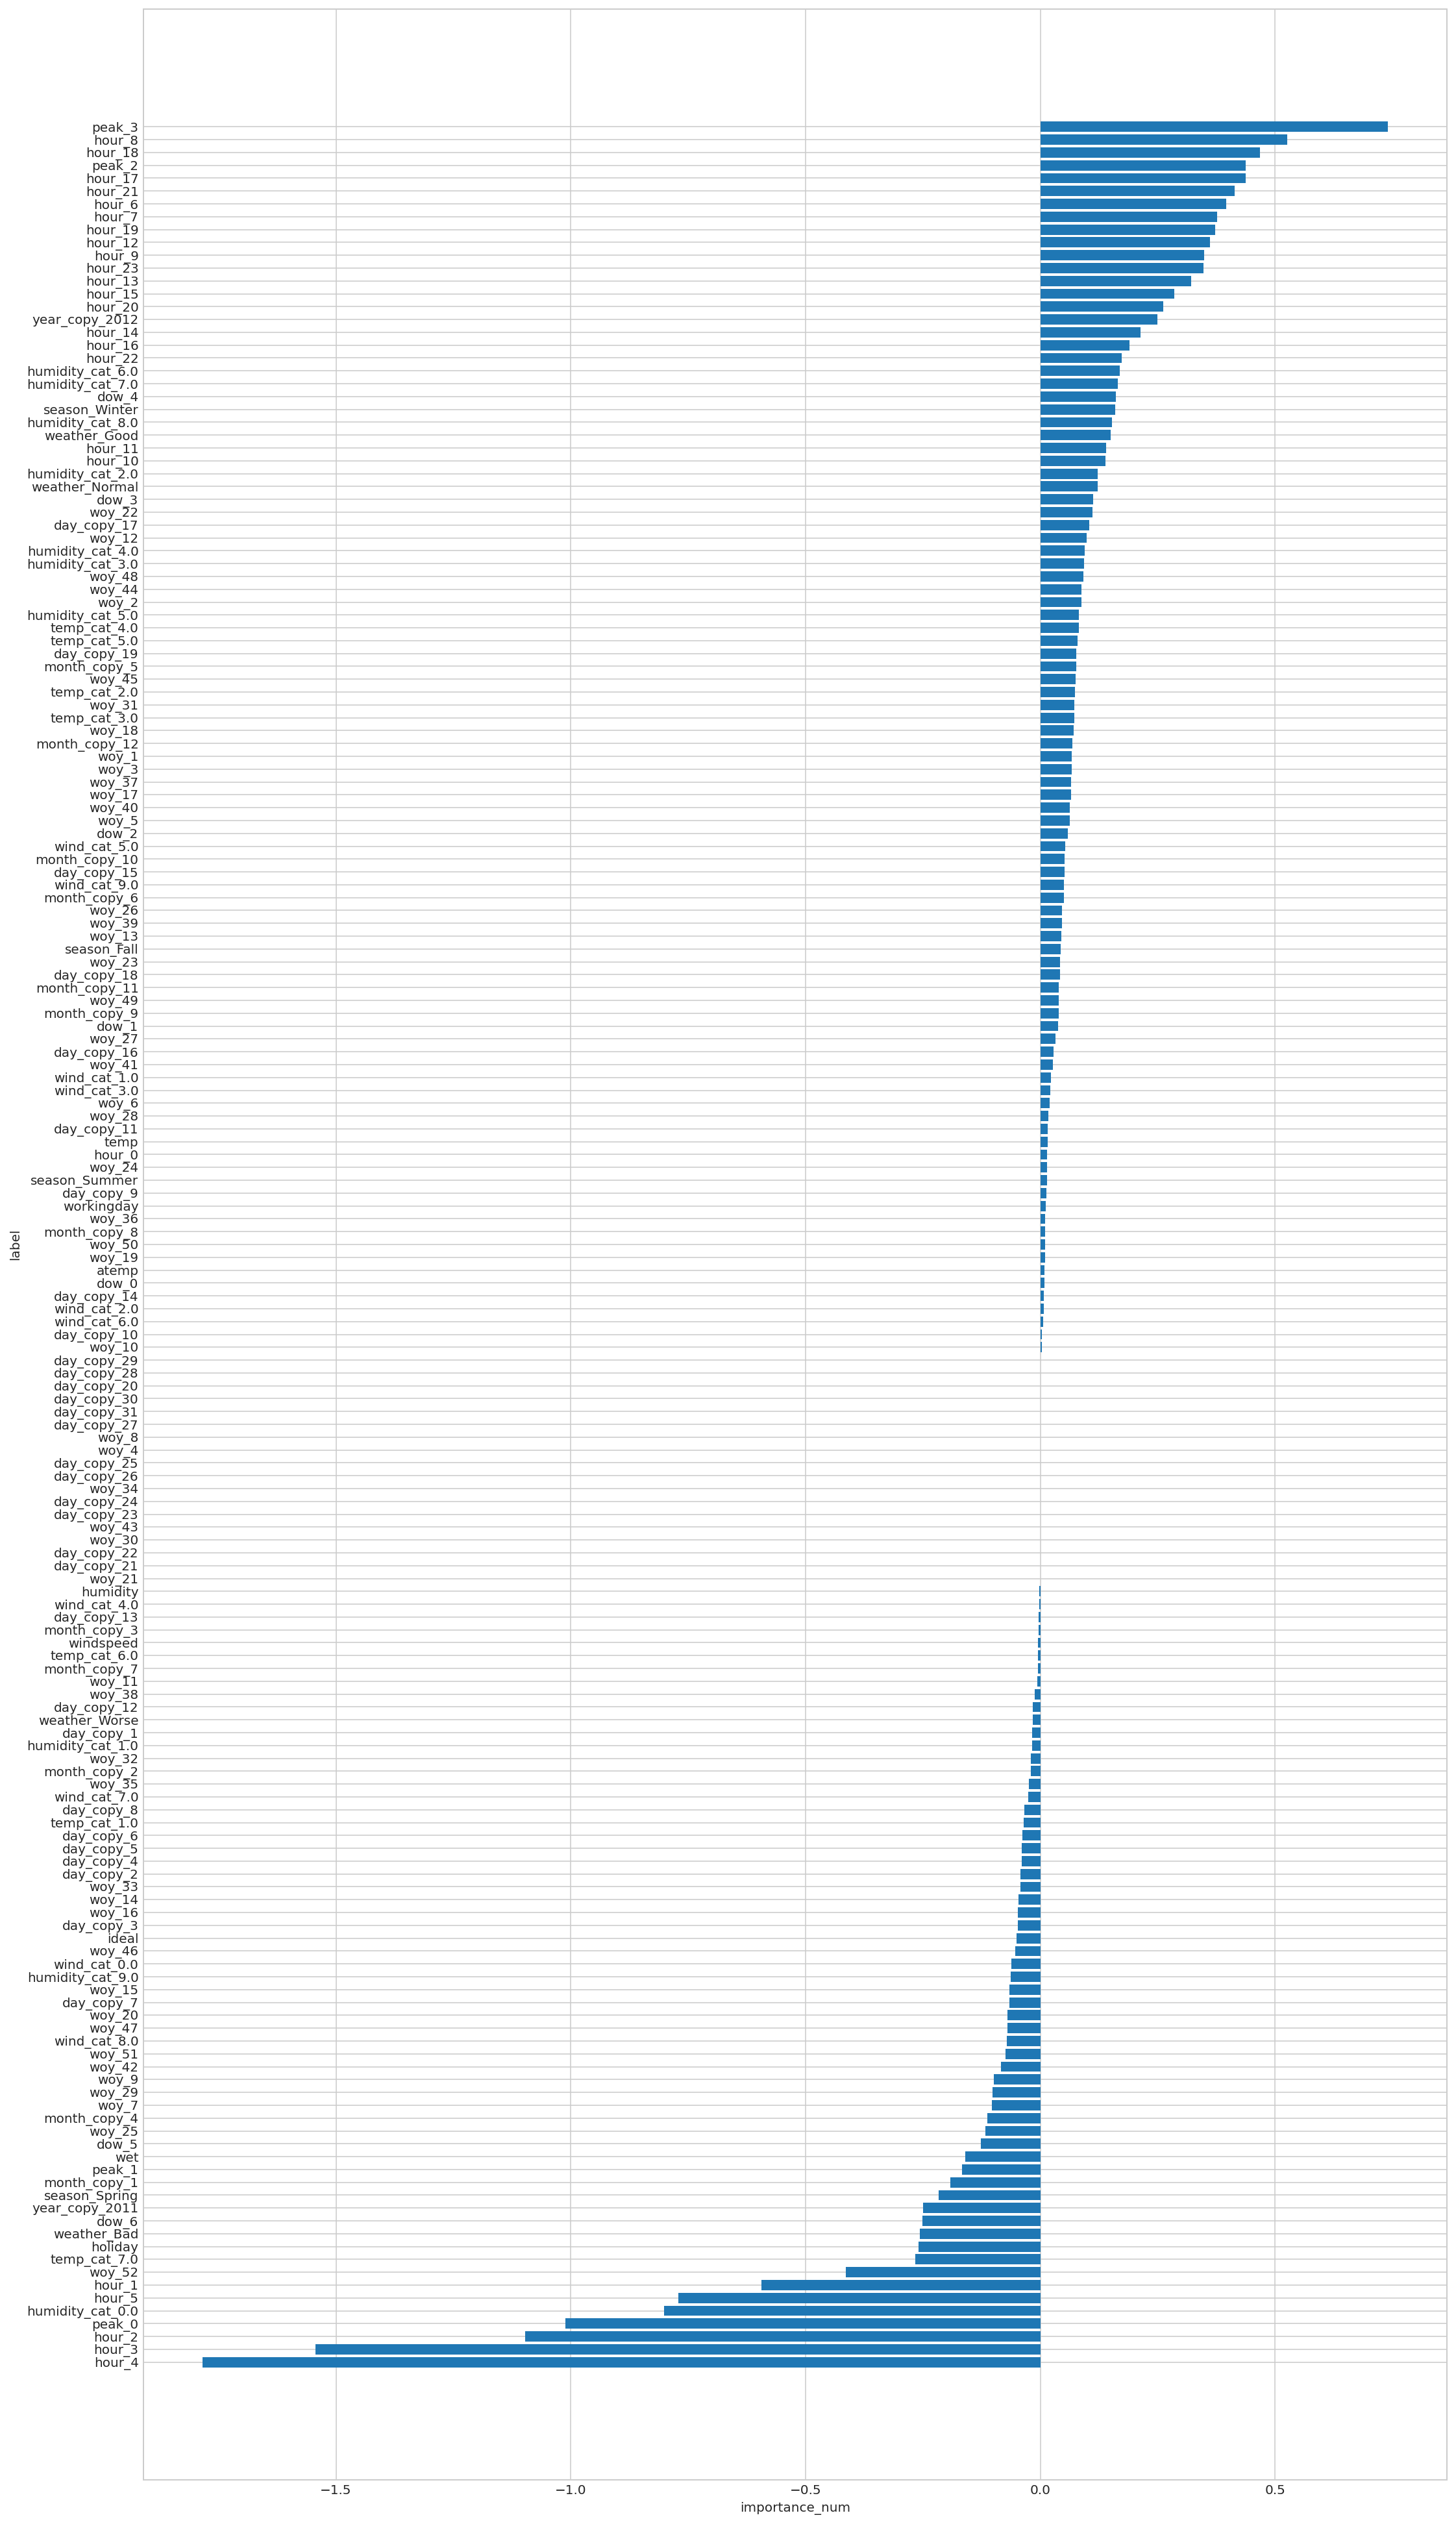

In [25]:
#特徴量の重要度
feature = ridge_model.coef_
#特徴量の名前
label = train_df[ridge_cols].columns[0:]
#特徴量の重要度順(降順)
indices = np.argsort(feature)[::1]

# プロット
fig, ax = plt.subplots(figsize=(18, 35))
x = range(len(feature))
y = feature[indices]
y_label = label[indices]
plt.barh(x, y, align = 'center')
plt.yticks(x, y_label)
plt.xlabel("importance_num")
plt.ylabel("label")
plt.show()